In [1]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.layers import Input, Dropout, Dense, GlobalAveragePooling2D
from keras.models import Sequential, Model
from keras.applications.resnet import ResNet50
from keras.applications import VGG16, DenseNet121, InceptionV3, VGG19, Xception, MobileNetV2, EfficientNetB0
from tensorboard import notebook
from tensorflow import keras
import numpy as np
import sys
sys.path.append("/root/autodl-tmp/training_tool/")
from training_tool import load_data, draw_curve, draw_matrix, TimeHistory
from tensorflow.keras.layers import ( Input, Conv2D, BatchNormalization, ReLU, MaxPooling2D, Concatenate, GlobalMaxPooling2D, Dropout,
    Dense, Lambda, Reshape, Activation, Multiply, Add, UpSampling2D, LayerNormalization, Flatten, AveragePooling2D )
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import tensorflow as tf

2024-03-18 16:05:29.705273: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


100%|██████████| 300/300 [00:00<00:00, 442.73it/s]


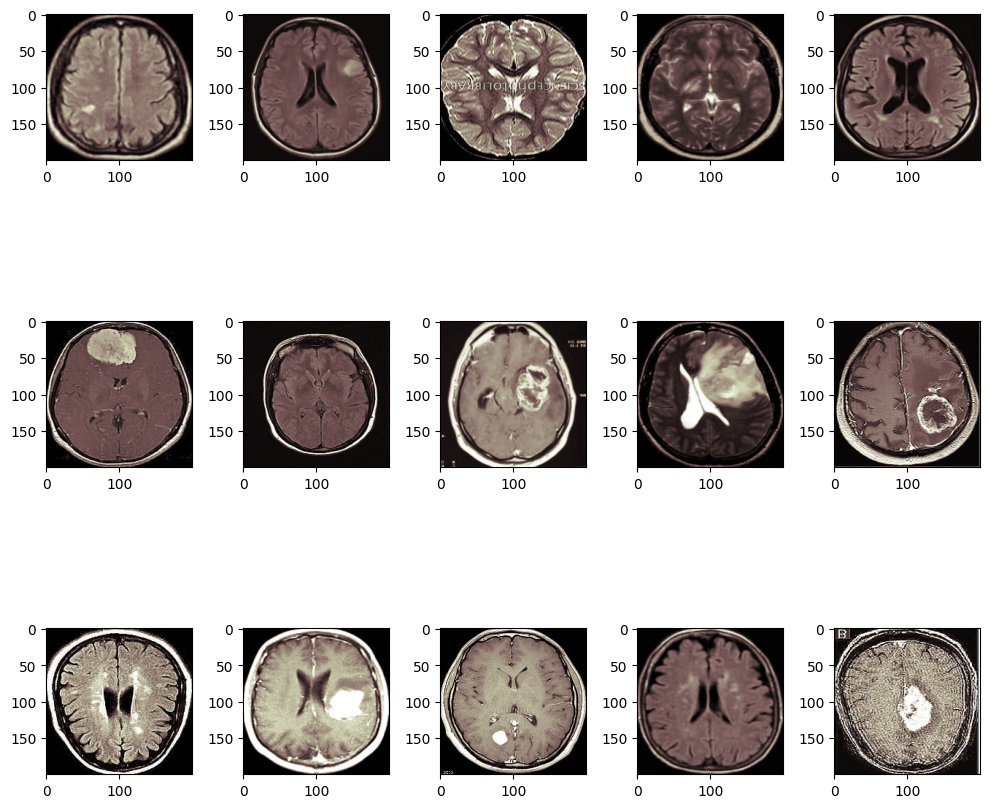

In [2]:
labels = ['yes', 'no']
data_path = '/root/autodl-tmp/dataset/Br35H/cropped'
image_size = 200
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)

## ARM-Net

In [3]:
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    BatchNormalization,
    ReLU,
    MaxPooling2D,
    Concatenate,
    GlobalMaxPooling2D,
    Dropout,
    Dense,
    Lambda,
    Reshape,
    Activation,
    Multiply,
    Add
)
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

def block(inputs, filters):
    a = Conv2D(filters, 3, padding='same')(inputs)
    a = BatchNormalization()(a)
    a = ReLU()(a)
    
    b = Conv2D(filters, 3, padding='same')(a)
    b = BatchNormalization()(b)
    b = ReLU()(b)
    
    c = Conv2D(filters, 3, padding='same')(b)
    c = BatchNormalization()(c)
    c = ReLU()(c)
    
    d = Conv2D(filters, 3, padding='same')(c)
    d = BatchNormalization()(d)
    d = ReLU()(d)
    
    mid = Concatenate()([a, b, c, d])
    mid = Conv2D(2 * filters, 1, padding='same')(mid)
    mid = BatchNormalization()(mid)
    mid = ReLU()(mid)
    
    x = Conv2D(filters * 2, 1)(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = Add()([mid, x])
    
    y = Conv2D(filters * 2, 1)(x)
    y = BatchNormalization()(y)
    y = ReLU()(y)
    
    return y

def Global_attention_block(C_A):
    x = Lambda(lambda x: K.mean(x, axis=-1, keepdims=True))(C_A)
    y = Lambda(lambda x: K.max(x, axis=-1, keepdims=True))(C_A)
    
    x = Concatenate()([x, y])
    x = Activation('relu')(x)
    x = Conv2D(1, 1, padding='same')(x)
    x = Activation('sigmoid')(x)
    S_A = Multiply()([x, C_A])
    
    return S_A

def self_attention(inp):
    shp = inp.shape
    a = Conv2D(shp[3] // 8, 1, padding='same')(inp)
    a = Activation('relu')(a)
    
    b = Conv2D(shp[3] // 8, 1, padding='same')(inp)
    b = Activation('relu')(b)
    
    c = Conv2D(shp[3] // 8, 1, padding='same')(inp)
    c = Activation('relu')(c)
    
    a = Reshape((shp[1] * shp[2], shp[3] // 8))(a)
    b = Reshape((shp[1] * shp[2], shp[3] // 8))(b)
    b = K.permute_dimensions(b, (0, 2, 1))
    c = Reshape((shp[1] * shp[2], shp[3] // 8))(c)
    inter = K.batch_dot(a, b)
    inter = Activation('softmax')(inter)
    out = K.batch_dot(inter, c)
    out = Reshape((shp[1], shp[2], shp[3] // 8))(out)
    out = Conv2D(shp[3], 1, padding='same')(out)
    out = Activation('relu')(out)
    
    return out

def channel_attention(inputs):
    shape = K.int_shape(inputs)
    x = MaxPooling2D(pool_size=(shape[1], shape[2]))(inputs)
    x = Conv2D(shape[3] // 8, 1, padding='same', kernel_initializer='he_normal', use_bias=False)(x)
    x = Activation('relu')(x)
    x = Conv2D(shape[3], 1, padding='same', kernel_initializer='he_normal', use_bias=False)(x)
    x = Activation('sigmoid')(x)
    x = Multiply()([x, inputs])
    
    return x

def load_model():
    K.clear_session()
    inputs = Input(shape=(200, 200, 3))
    x = Conv2D(16, 3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(16, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D()(x)
    
    a1 = block(x, 32)
    x = MaxPooling2D()(a1)
    
    a2 = block(x, 64)
    x = MaxPooling2D()(a2)
    
    a3 = block(x, 128)
    a31 = self_attention(a3)
    a32 = Global_attention_block(a3)
    a3 = Add()([a31, a32])
    x = channel_attention(a3)
    
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(2, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=x)
    
    return model

2024-03-18 16:05:44.234172: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-18 16:05:44.602851: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22134 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:c3:00.0, compute capability: 8.9


Epoch 1/50


2024-03-18 16:05:49.437580: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200
2024-03-18 16:05:50.372343: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-03-18 16:05:50.372360: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2024-03-18 16:05:50.372404: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-03-18 16:05:50.882820: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


59/60 [============================>.] - ETA: 0s - loss: 0.7075 - accuracy: 0.5678
Epoch 1: saving model to ARM-Net.h5
Epoch 1: 6.86 seconds
60/60 [==============================] - 7s 32ms/step - loss: 0.7072 - accuracy: 0.5681 - val_loss: 0.6939 - val_accuracy: 0.5250 - lr: 1.0000e-04
Epoch 2/50
58/60 [============================>.] - ETA: 0s - loss: 0.5713 - accuracy: 0.7007
Epoch 2: saving model to ARM-Net.h5
Epoch 2: 1.40 seconds
60/60 [==============================] - 1s 23ms/step - loss: 0.5655 - accuracy: 0.7060 - val_loss: 0.7006 - val_accuracy: 0.4625 - lr: 1.0000e-04
Epoch 3/50
60/60 [==============================] - ETA: 0s - loss: 0.4362 - accuracy: 0.7949
Epoch 3: saving model to ARM-Net.h5
Epoch 3: 1.33 seconds
60/60 [==============================] - 1s 22ms/step - loss: 0.4362 - accuracy: 0.7949 - val_loss: 0.8564 - val_accuracy: 0.4750 - lr: 1.0000e-04
Epoch 4/50
59/60 [============================>.] - ETA: 0s - loss: 0.3630 - accuracy: 0.8413
Epoch 4: saving mode

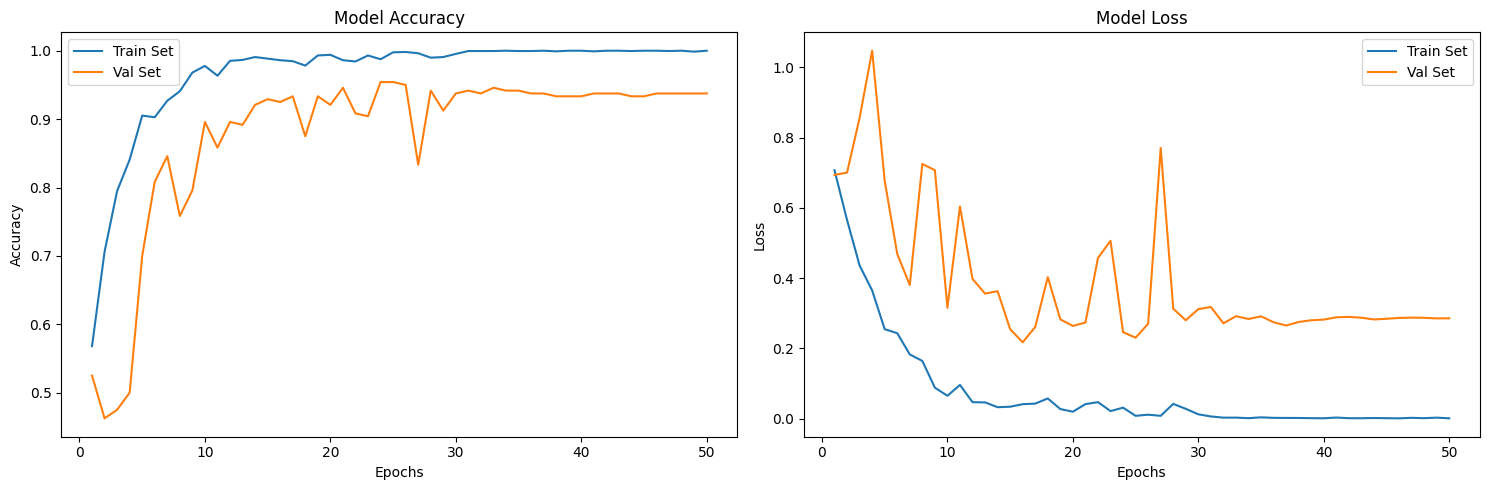

19/19 [==============================] - 0s 7ms/step - loss: 0.1422 - accuracy: 0.9683
Test Accuracy:  96.83
              precision    recall  f1-score   support

         yes     0.9795    0.9567    0.9680       300
          no     0.9577    0.9800    0.9687       300

    accuracy                         0.9683       600
   macro avg     0.9686    0.9683    0.9683       600
weighted avg     0.9686    0.9683    0.9683       600



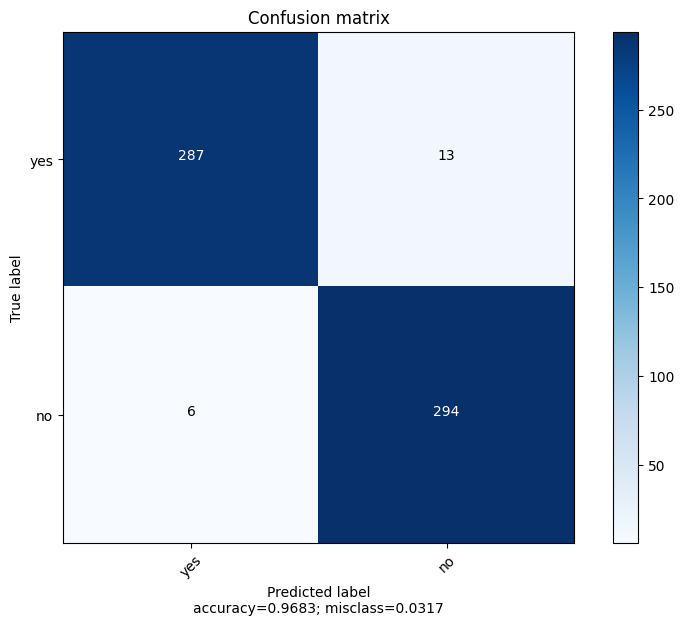

In [4]:
model = load_model()
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='ARM-Net.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])

draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

## MFL-Net

In [5]:
def mini_block(filters, x):
    conv = tf.keras.layers.Conv2D(filters , kernel_size=(3, 3),padding = "same")(x)
    bn = tf.keras.layers.BatchNormalization()(conv)
    act = tf.keras.layers.ReLU()(bn)
    return act

def double_mini_block(filters, x):
    t = mini_block(filters, x)
    t = mini_block(filters, t)
    return t

def MFL_Block(f,inp):
    block1 = mini_block(f,inp)
    block2 = double_mini_block(f,inp)
    c1 =  Concatenate()([block1, block2])
    conv = tf.keras.layers.Conv2D(f , kernel_size=(1, 1))(c1)
    block3 = mini_block(f,conv)
    block4 = mini_block(f,inp)
    c2 = Concatenate()([block3, block4])
    conv = tf.keras.layers.Conv2D(f, kernel_size=(1, 1))(c2)
    return conv

def MFL_Net():
    inp = tf.keras.layers.Input(shape=(200,200,3))
    b1 = mini_block(16,inp)
    pool = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(b1)
    p1 = MFL_Block(16,pool)
    pool = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(p1)
    p2 = MFL_Block(32,pool)
    pool = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(p2)
    p3 = MFL_Block(64,pool)
    pool = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(p3)
    p4 = MFL_Block(128,pool)
    globavg = tf.keras.layers.GlobalAveragePooling2D()(p4)
    drop = tf.keras.layers.Dropout(rate=0.5)(globavg)
    out = tf.keras.layers.Dense(2, activation='softmax')(drop)
    model = tf.keras.Model(inputs=inp, outputs=out)
    return model

Epoch 1/50
58/60 [============================>.] - ETA: 0s - loss: 0.6311 - accuracy: 0.6652
Epoch 1: saving model to MFL-Net.h5
Epoch 1: 3.46 seconds
60/60 [==============================] - 3s 30ms/step - loss: 0.6296 - accuracy: 0.6671 - val_loss: 0.7089 - val_accuracy: 0.5250 - lr: 1.0000e-04
Epoch 2/50
58/60 [============================>.] - ETA: 0s - loss: 0.4811 - accuracy: 0.7787
Epoch 2: saving model to MFL-Net.h5
Epoch 2: 1.45 seconds
60/60 [==============================] - 1s 24ms/step - loss: 0.4789 - accuracy: 0.7782 - val_loss: 0.7101 - val_accuracy: 0.5250 - lr: 1.0000e-04
Epoch 3/50
58/60 [============================>.] - ETA: 0s - loss: 0.4111 - accuracy: 0.8084
Epoch 3: saving model to MFL-Net.h5
Epoch 3: 1.41 seconds
60/60 [==============================] - 1s 24ms/step - loss: 0.4089 - accuracy: 0.8106 - val_loss: 0.8755 - val_accuracy: 0.5333 - lr: 1.0000e-04
Epoch 4/50
58/60 [============================>.] - ETA: 0s - loss: 0.3354 - accuracy: 0.8482
Epoch 4: 

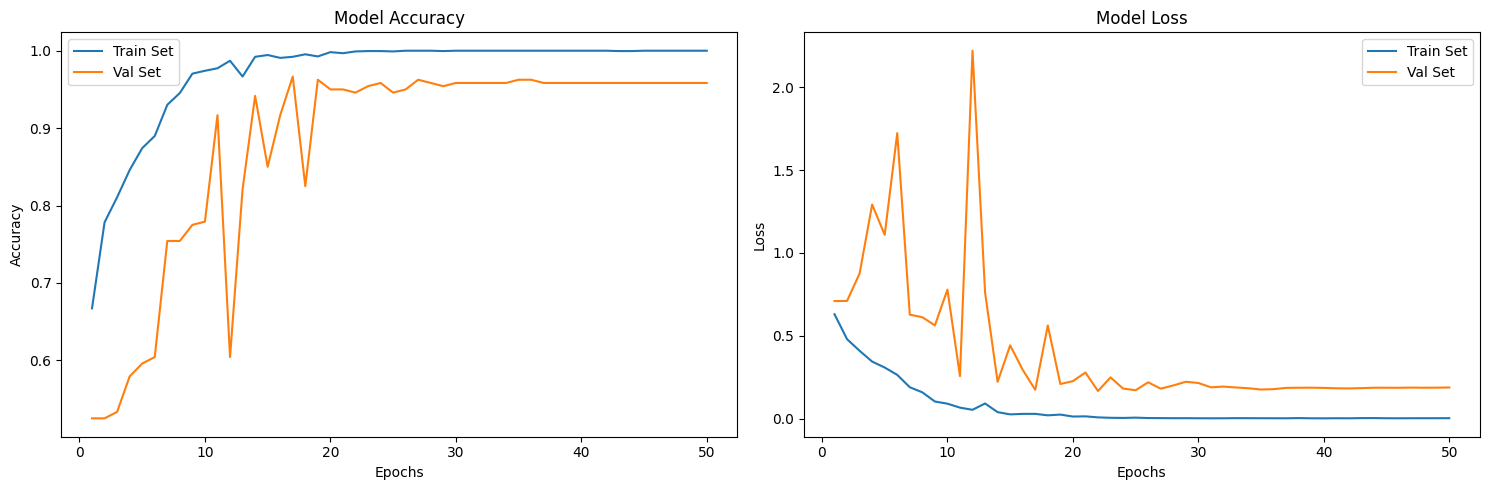

19/19 [==============================] - 0s 7ms/step - loss: 0.1215 - accuracy: 0.9633
Test Accuracy:  96.33
              precision    recall  f1-score   support

         yes     0.9603    0.9667    0.9635       300
          no     0.9664    0.9600    0.9632       300

    accuracy                         0.9633       600
   macro avg     0.9634    0.9633    0.9633       600
weighted avg     0.9634    0.9633    0.9633       600



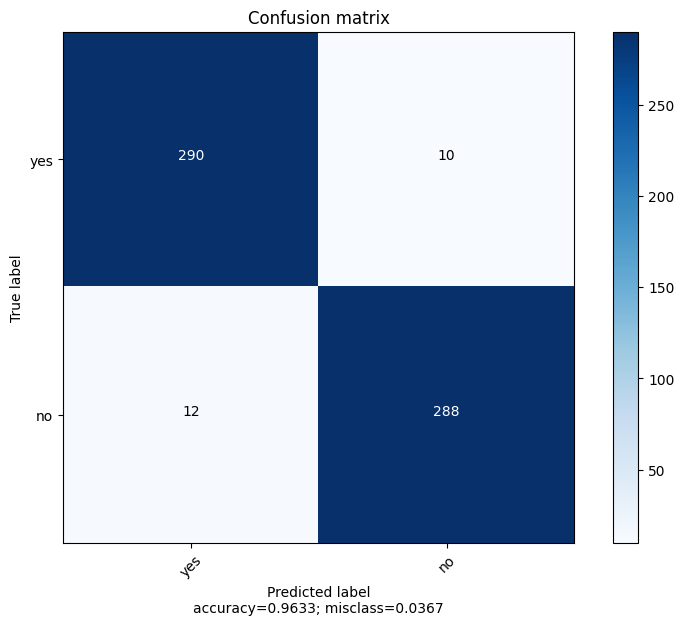

In [6]:
model = MFL_Net()
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='MFL-Net.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])

draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

## CDANet

In [7]:
def PAB(inputs, channel_size):

    b, h, w, c = inputs.shape.as_list()

    x = Lambda(lambda x: K.mean(x, axis=-1, keepdims=True))(inputs)
    x = tf.reshape(x, [-1, 1, h*w])
    x = Activation('sigmoid')(x)
    x = K.batch_dot(x, tf.reshape(inputs, [-1, h*w, channel_size]))
    x = tf.reshape(x, [-1, 1, 1, channel_size])
    
    return x

def CAB(inputs, reduction=8):
    shape = K.int_shape(inputs)

    x = MaxPooling2D(pool_size=(shape[1], shape[2]))(inputs)
    x = Conv2D(shape[3] // reduction, 1, padding='same', kernel_initializer='he_normal', use_bias=False)(x)
    x = Activation('relu')(x)
    x = Conv2D(shape[3], 1, padding='same', kernel_initializer='he_normal', use_bias=False)(x)
    x = Activation('sigmoid')(x)
    
    return x
    
    
def CSDA(inputs,batch_size):

    f1 = []
    f2 = []
    half_size = inputs.shape[-1] // 2

    SPC_out = Lambda(lambda x: tf.split(x, num_or_size_splits=2, axis=-1))(inputs)
    

    f1 = SPC_out[0]
    f2 = SPC_out[1]

    x = Concatenate()([CAB(f1), PAB(f1, half_size)])
    x = Conv2D(half_size, 1, padding='same')(x)
    x = Activation('sigmoid')(x)
    f1 = Multiply()([x, f1])

    y = Concatenate()([CAB(f2), PAB(f2, half_size)])
    y = Conv2D(half_size, 1, padding='same')(y)
    y = Activation('sigmoid')(y)
    f2 = Multiply()([y, f2])

    outputs = Concatenate()([f1, f2])
        
    return outputs
    
    
        

def load_model():
    K.clear_session()
    inputs = Input(shape=(200, 200, 3))
    shape = K.int_shape(inputs)

    net = DenseNet121(weights=None, include_top=False, input_shape=(200, 200, 3))
    x = net.output
    
    x = CSDA(x, 36)
    
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(2, activation='softmax')(x)
    model = Model(inputs= net.input, outputs=x)
    
    return model


Epoch 1/50
60/60 [==============================] - ETA: 0s - loss: 0.5391 - accuracy: 0.7218
Epoch 1: saving model to CDANet.h5
Epoch 1: 13.27 seconds
60/60 [==============================] - 13s 99ms/step - loss: 0.5391 - accuracy: 0.7218 - val_loss: 0.7409 - val_accuracy: 0.5250 - lr: 1.0000e-04
Epoch 2/50
60/60 [==============================] - ETA: 0s - loss: 0.3536 - accuracy: 0.8421
Epoch 2: saving model to CDANet.h5
Epoch 2: 4.48 seconds
60/60 [==============================] - 4s 75ms/step - loss: 0.3536 - accuracy: 0.8421 - val_loss: 1.6414 - val_accuracy: 0.5250 - lr: 1.0000e-04
Epoch 3/50
60/60 [==============================] - ETA: 0s - loss: 0.2777 - accuracy: 0.8912
Epoch 3: saving model to CDANet.h5
Epoch 3: 4.58 seconds
60/60 [==============================] - 5s 77ms/step - loss: 0.2777 - accuracy: 0.8912 - val_loss: 2.3870 - val_accuracy: 0.5250 - lr: 1.0000e-04
Epoch 4/50
60/60 [==============================] - ETA: 0s - loss: 0.2445 - accuracy: 0.8944
Epoch 4: s

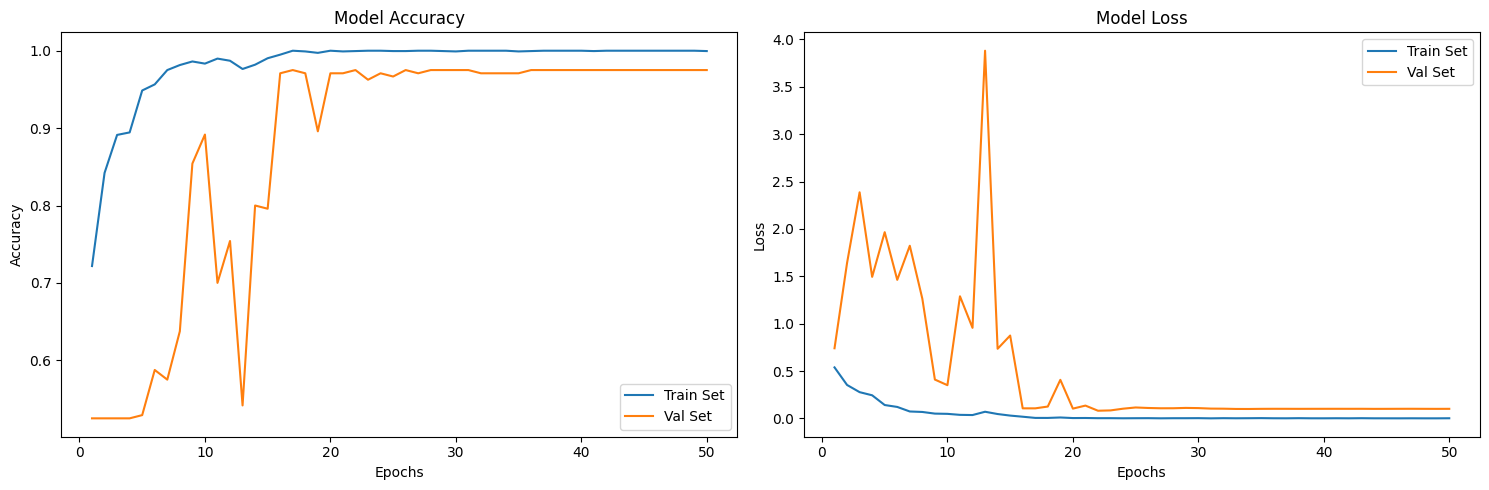

19/19 [==============================] - 0s 19ms/step - loss: 0.0526 - accuracy: 0.9850
Test Accuracy:  98.5
              precision    recall  f1-score   support

         yes     0.9932    0.9767    0.9849       300
          no     0.9770    0.9933    0.9851       300

    accuracy                         0.9850       600
   macro avg     0.9851    0.9850    0.9850       600
weighted avg     0.9851    0.9850    0.9850       600



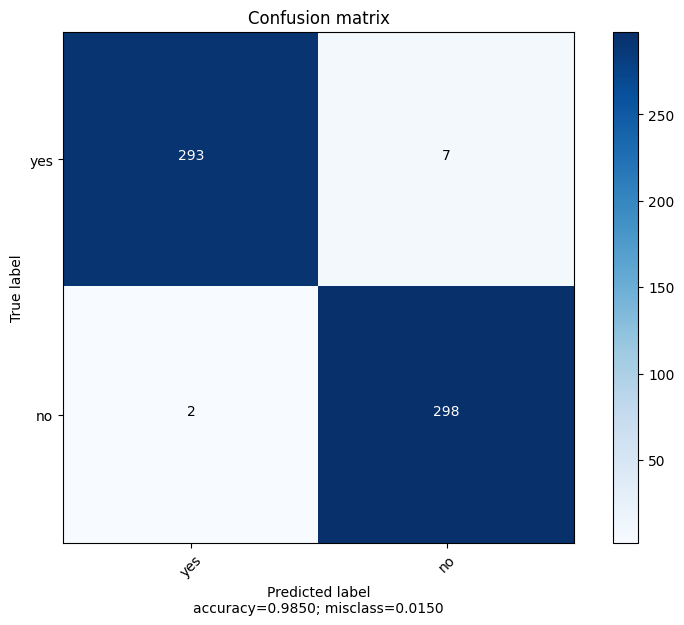

In [8]:
model = load_model()
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='CDANet.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])

draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

## CapsNet

100%|██████████| 300/300 [00:00<00:00, 431.28it/s]


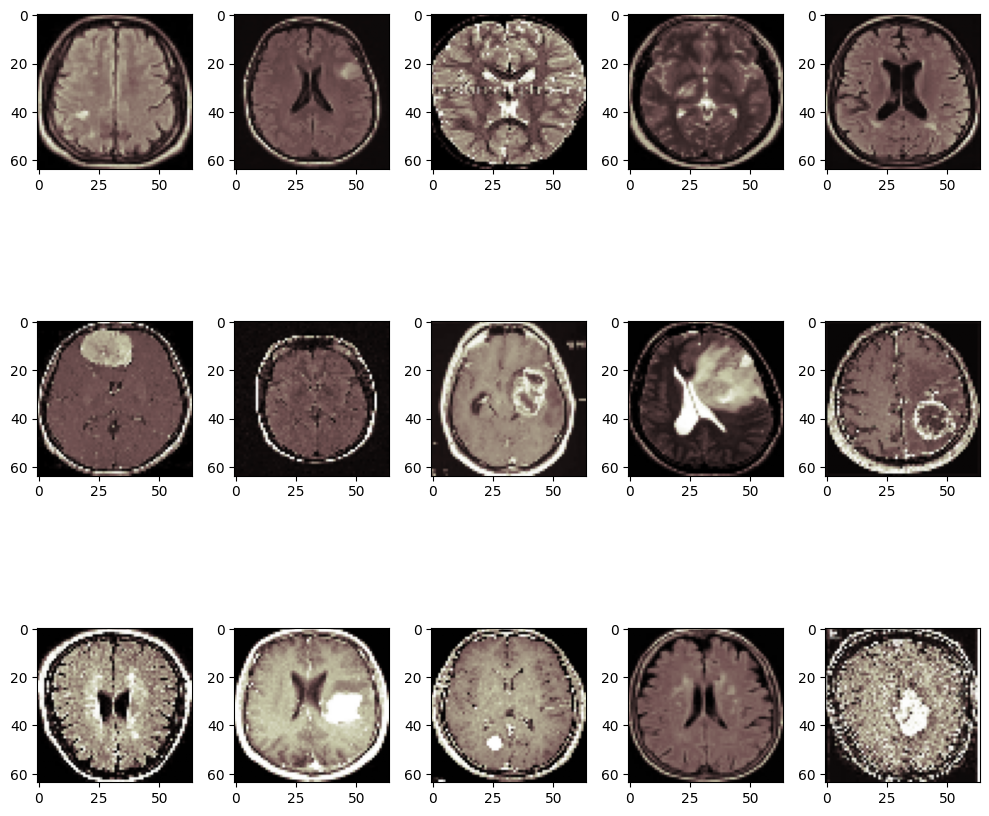

In [10]:
labels = ['yes', 'no']
data_path = '/root/autodl-tmp/dataset/Br35H/cropped'
image_size = 64
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)

In [11]:
sys.path.append("/root/autodl-tmp/model/CapsuleNet/capsnet-keras/")
from capsulelayers import CapsuleLayer, PrimaryCap, Length, Mask
from keras import models, layers
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    BatchNormalization,
    ReLU,
    MaxPooling2D,
    Concatenate,
    GlobalMaxPooling2D,
    Dropout,
    Dense,
    Lambda,
    Reshape,
    Activation,
    Multiply,
    Add
)
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K


def load_model():
    K.clear_session()
    inputs = Input(shape=(64, 64, 3))

    conv1 = layers.Conv2D(64, (9, 9), activation='relu', name="FirstLayer")(inputs)

    primaryCaps = PrimaryCap(inputs=conv1, dim_capsule=8, n_channels=32, kernel_size=9, strides=2, padding='valid')
    
    capLayer2 = CapsuleLayer(num_capsule=3, dim_capsule=16, routings=2, name="ThirdLayer")(primaryCaps)
    
    x = GlobalAveragePooling2D()(capLayer2)
    x = Dropout(0.5)(x)
    x = Dense(2, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=x)
    
    return model

Epoch 1/50
60/60 [==============================] - ETA: 0s - loss: 0.6708 - accuracy: 0.5514
Epoch 1: saving model to CapsNet.h5
Epoch 1: 2.79 seconds
60/60 [==============================] - 3s 33ms/step - loss: 0.6708 - accuracy: 0.5514 - val_loss: 0.6000 - val_accuracy: 0.6542 - lr: 1.0000e-04
Epoch 2/50
60/60 [==============================] - ETA: 0s - loss: 0.5862 - accuracy: 0.6847
Epoch 2: saving model to CapsNet.h5
Epoch 2: 1.68 seconds
60/60 [==============================] - 2s 28ms/step - loss: 0.5862 - accuracy: 0.6847 - val_loss: 0.5191 - val_accuracy: 0.7542 - lr: 1.0000e-04
Epoch 3/50
59/60 [============================>.] - ETA: 0s - loss: 0.5393 - accuracy: 0.7406
Epoch 3: saving model to CapsNet.h5
Epoch 3: 1.79 seconds
60/60 [==============================] - 2s 30ms/step - loss: 0.5399 - accuracy: 0.7394 - val_loss: 0.4607 - val_accuracy: 0.8042 - lr: 1.0000e-04
Epoch 4/50
59/60 [============================>.] - ETA: 0s - loss: 0.4790 - accuracy: 0.7933
Epoch 4: 

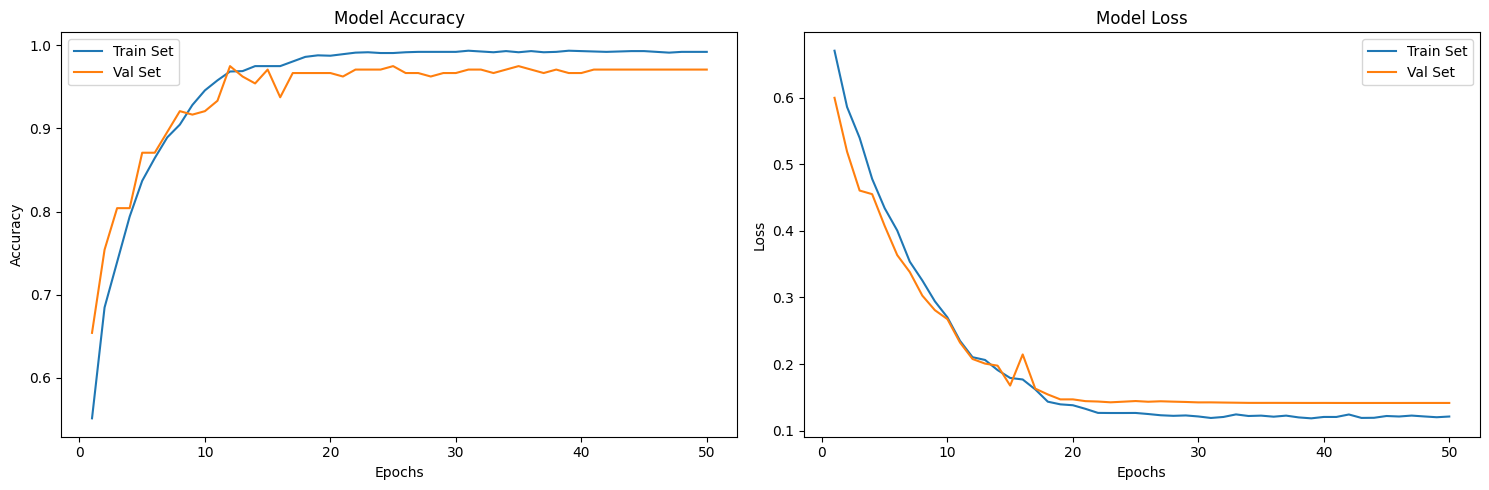

19/19 [==============================] - 0s 9ms/step - loss: 0.1952 - accuracy: 0.9433
Test Accuracy:  94.33
              precision    recall  f1-score   support

         yes     0.9650    0.9200    0.9420       300
          no     0.9236    0.9667    0.9446       300

    accuracy                         0.9433       600
   macro avg     0.9443    0.9433    0.9433       600
weighted avg     0.9443    0.9433    0.9433       600



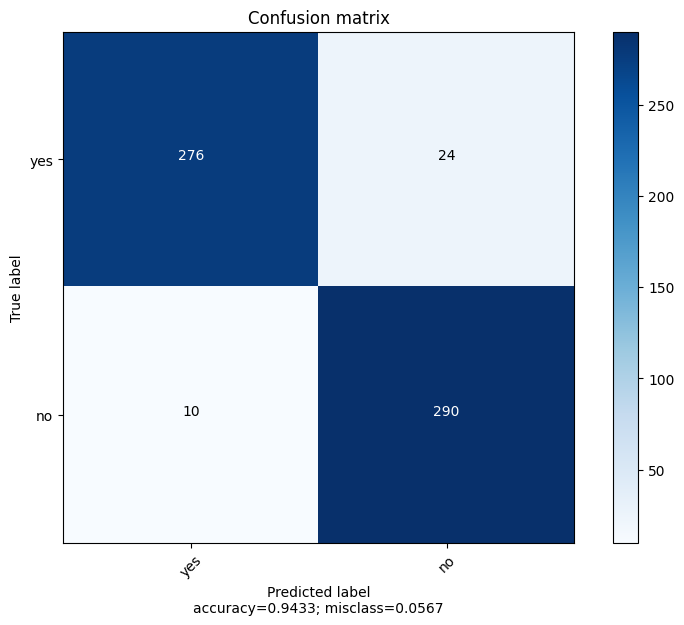

In [12]:
model = load_model()
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='CapsNet.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])

draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

## NeuroNet19

100%|██████████| 300/300 [00:00<00:00, 452.14it/s]


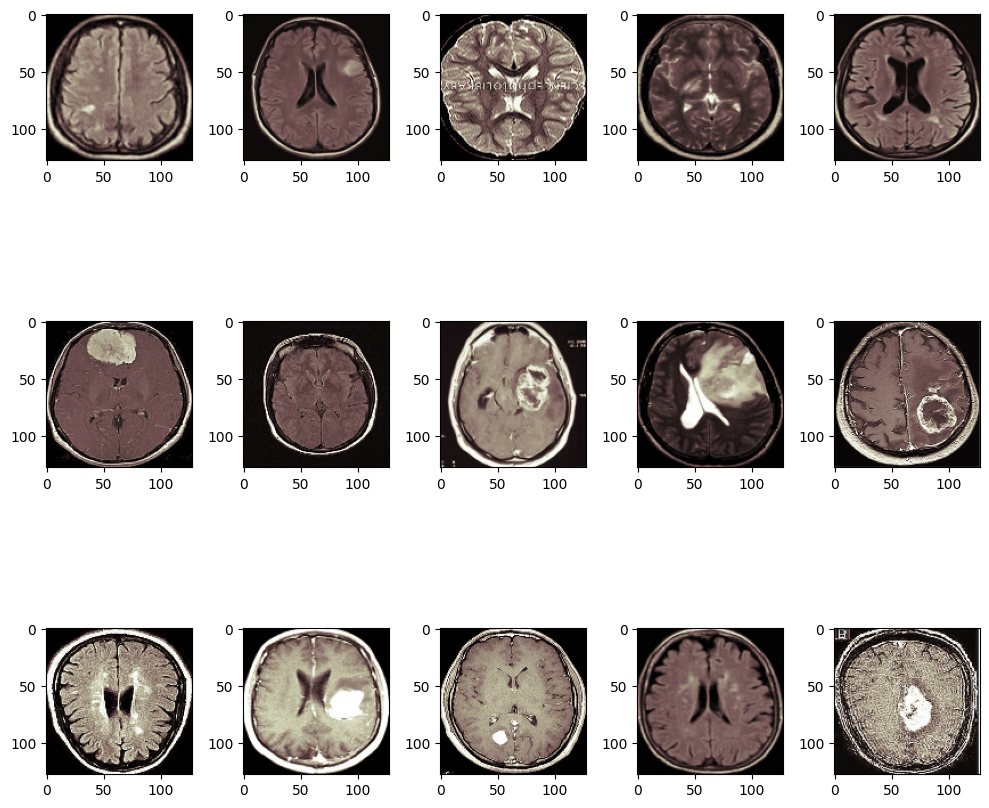

In [13]:
labels = ['yes', 'no']
data_path = '/root/autodl-tmp/dataset/Br35H/cropped'
image_size = 128
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)

In [14]:
from tensorflow.keras.layers import ( Input, Conv2D, BatchNormalization, ReLU, MaxPooling2D, Concatenate, GlobalMaxPooling2D, Dropout,
    Dense, Lambda, Reshape, Activation, Multiply, Add, UpSampling2D )
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K


def load_model():


    net = VGG19(weights=None, include_top=False, input_shape=(128, 128, 3))
    x = net.output

    a = UpSampling2D(size=(6, 6))(x)
    a = MaxPooling2D(pool_size=(6, 6))(a)
    a = Conv2D(128, 1, padding='same')(a)

    b = UpSampling2D(size=(4, 4))(x)
    b = MaxPooling2D(pool_size=(4, 4))(b)
    b = Conv2D(128, 1, padding='same')(b)

    c = UpSampling2D(size=(3, 3))(x)
    c = MaxPooling2D(pool_size=(3, 3))(c)
    c = Conv2D(128, 1, padding='same')(c)

    d = UpSampling2D(size=(2, 2))(x)
    d = MaxPooling2D(pool_size=(2, 2))(d)
    d = Conv2D(128, 1, padding='same')(d)

    x =  Concatenate()([a, b, c, d])
    x = Conv2D(256, 1, padding='same')(x)
    x = Conv2D(128, 1, padding='same')(x)
    
    x = GlobalAveragePooling2D()(x)
    x = Dense(2, activation='softmax')(x)
    model = Model(inputs=net.input, outputs=x)
    
    return model



Epoch 1/50
59/60 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.4699
Epoch 1: saving model to NeuroNet19.h5
Epoch 1: 4.20 seconds
60/60 [==============================] - 4s 46ms/step - loss: 0.6935 - accuracy: 0.4722 - val_loss: 0.6934 - val_accuracy: 0.4750 - lr: 1.0000e-04
Epoch 2/50
59/60 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5028
Epoch 2: saving model to NeuroNet19.h5
Epoch 2: 2.36 seconds
60/60 [==============================] - 2s 39ms/step - loss: 0.6934 - accuracy: 0.5028 - val_loss: 0.6932 - val_accuracy: 0.4750 - lr: 1.0000e-04
Epoch 3/50
59/60 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.4896
Epoch 3: saving model to NeuroNet19.h5
Epoch 3: 2.37 seconds
60/60 [==============================] - 2s 40ms/step - loss: 0.6933 - accuracy: 0.4926 - val_loss: 0.6935 - val_accuracy: 0.4750 - lr: 1.0000e-04
Epoch 4/50
59/60 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.5033


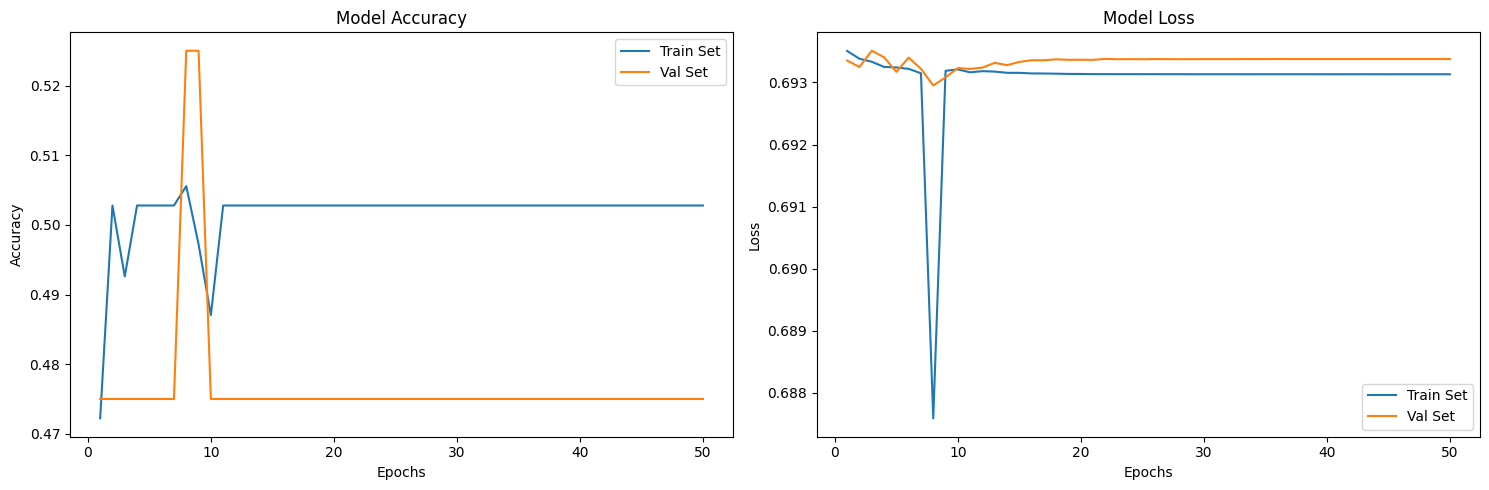

19/19 [==============================] - 0s 10ms/step - loss: 0.6932 - accuracy: 0.5000
Test Accuracy:  50.0
              precision    recall  f1-score   support

         yes     0.5000    1.0000    0.6667       300
          no     0.0000    0.0000    0.0000       300

    accuracy                         0.5000       600
   macro avg     0.2500    0.5000    0.3333       600
weighted avg     0.2500    0.5000    0.3333       600



/root/miniconda3/envs/tumor/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/miniconda3/envs/tumor/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/miniconda3/envs/tumor/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


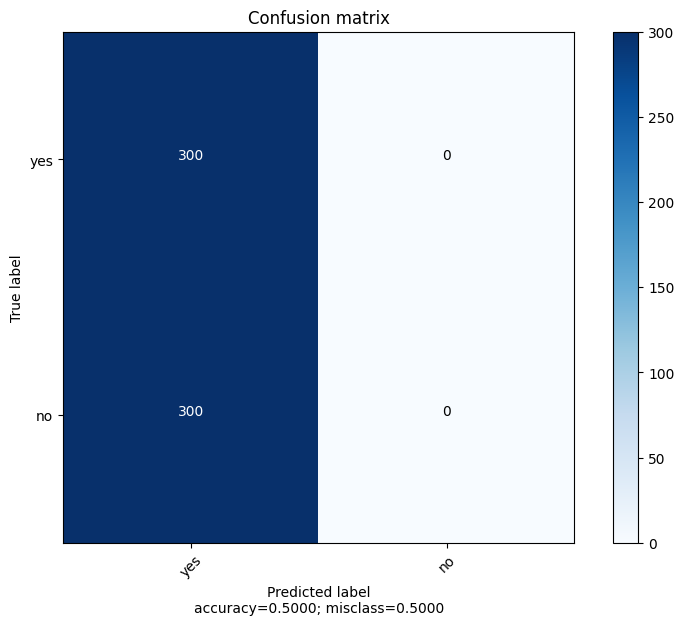

In [15]:
model = load_model()
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='NeuroNet19.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])

draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

## WeightedEM

100%|██████████| 300/300 [00:00<00:00, 439.58it/s]


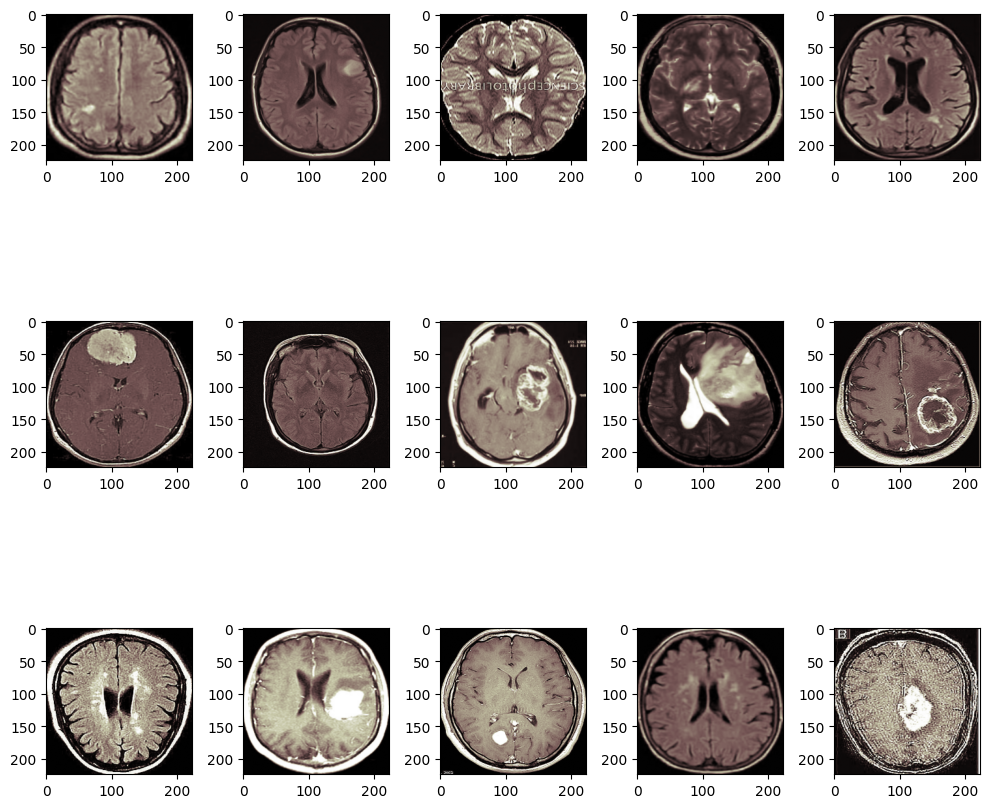

In [22]:
labels = ['yes', 'no']
data_path = '/root/autodl-tmp/dataset/Br35H/cropped'
image_size = 224
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)

In [23]:
def CNN(inputs):
    
    x = Conv2D(32, 3, strides=4, padding='same')(inputs)
    x = ReLU()(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.1)(x)

    x = Conv2D(64, 3, strides=4, padding='same')(inputs)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(128, 3, strides=4, padding='same')(inputs)
    x = ReLU()(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.1)(x)

    x = Conv2D(256, 3, strides=4, padding='same')(inputs)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(512, 3, strides=4, padding='same')(inputs)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)


    return x


def load_model():
    K.clear_session()
    inputs = Input(shape=(224, 224, 3))

    net = VGG19(weights=None, include_top=False, input_shape=(224, 224, 3))
    x = net.output
    x = GlobalAveragePooling2D()(x)
    x = x * 0.3

    y = CNN(net.input)
    y = GlobalAveragePooling2D()(y)
    y = y * 0.4

    z = CNN(net.input)
    z = GlobalAveragePooling2D()(z)
    z = z * 0.4

    k = Add()([x, y, z])
    
    k = Dropout(0.5)(k)
    k = Dense(2, activation='softmax')(k)
    model = Model(inputs= net.input, outputs=k)
    
    return model


Epoch 1/50
60/60 [==============================] - ETA: 0s - loss: 0.6909 - accuracy: 0.4944
Epoch 1: saving model to WeightedEM.h5
Epoch 1: 7.52 seconds
60/60 [==============================] - 8s 115ms/step - loss: 0.6909 - accuracy: 0.4944 - val_loss: 0.6870 - val_accuracy: 0.5417 - lr: 1.0000e-04
Epoch 2/50
60/60 [==============================] - ETA: 0s - loss: 0.6668 - accuracy: 0.5806
Epoch 2: saving model to WeightedEM.h5
Epoch 2: 6.61 seconds
60/60 [==============================] - 7s 110ms/step - loss: 0.6668 - accuracy: 0.5806 - val_loss: 0.6288 - val_accuracy: 0.6208 - lr: 1.0000e-04
Epoch 3/50
60/60 [==============================] - ETA: 0s - loss: 0.6526 - accuracy: 0.6162
Epoch 3: saving model to WeightedEM.h5
Epoch 3: 6.61 seconds
60/60 [==============================] - 7s 110ms/step - loss: 0.6526 - accuracy: 0.6162 - val_loss: 0.6140 - val_accuracy: 0.6417 - lr: 1.0000e-04
Epoch 4/50
60/60 [==============================] - ETA: 0s - loss: 0.6391 - accuracy: 0.63

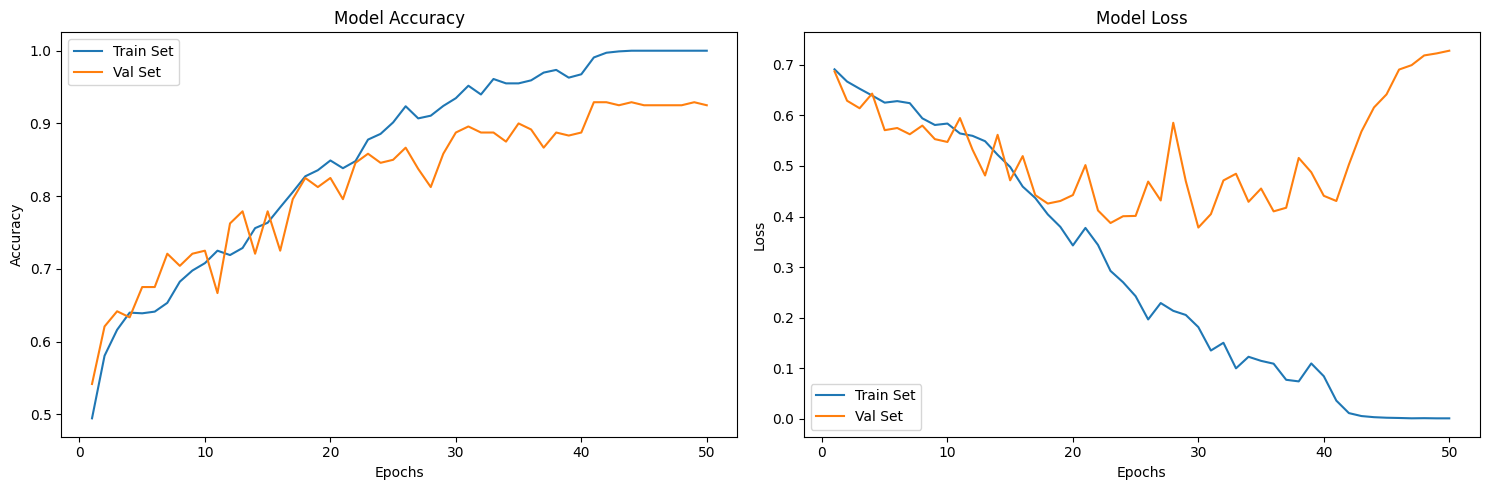

19/19 [==============================] - 1s 33ms/step - loss: 0.7429 - accuracy: 0.9217
Test Accuracy:  92.17
              precision    recall  f1-score   support

         yes     0.9317    0.9100    0.9207       300
          no     0.9121    0.9333    0.9226       300

    accuracy                         0.9217       600
   macro avg     0.9219    0.9217    0.9217       600
weighted avg     0.9219    0.9217    0.9217       600



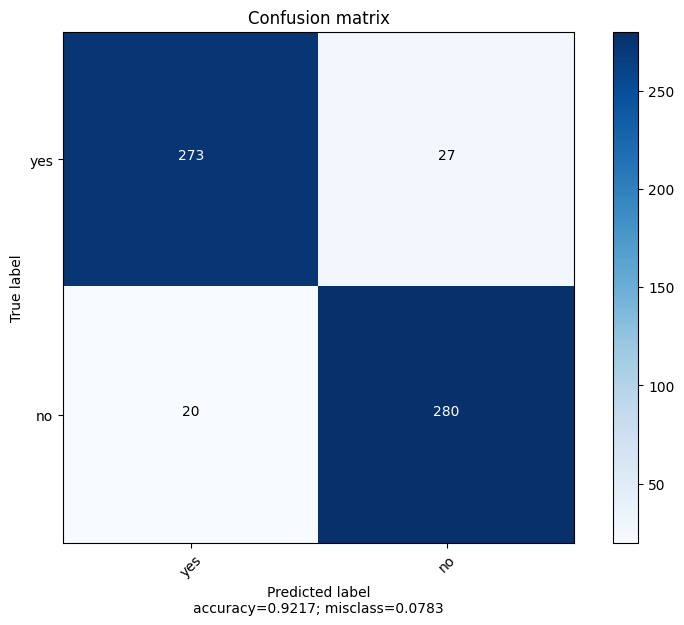

In [24]:
model = load_model()
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='WeightedEM.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])

draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

## DNNwithSVM

100%|██████████| 300/300 [00:00<00:00, 432.75it/s]


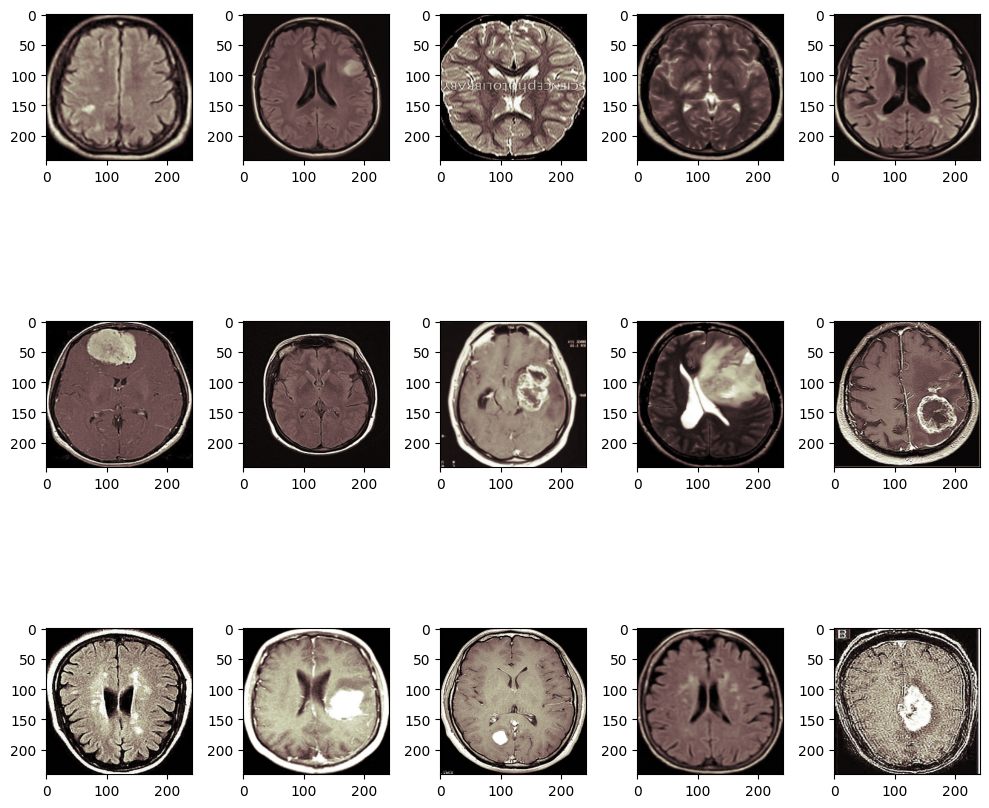

In [19]:
labels = ['yes', 'no']
data_path = '/root/autodl-tmp/dataset/Br35H/cropped'
image_size = 241
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)

In [20]:
def load_model():
    K.clear_session()
    inputs = Input(shape=(241, 241, 3))

    x = Conv2D(96, 9, strides=4, padding='valid')(inputs)
    x = ReLU()(x)
    x = LayerNormalization()(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid')(x)

    x = Conv2D(256, 7, strides=1, padding='same')(x)
    x = ReLU()(x)
    x = LayerNormalization()(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid')(x)

    x = Conv2D(384, 3, strides=1, padding='same')(x)
    x = ReLU()(x)

    x = Conv2D(384, 3, strides=1, padding='same')(x)
    x = ReLU()(x)

    x = Conv2D(256, 3, strides=1, padding='same')(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid')(x)

    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(2, activation='softmax')(x)
    model = Model(inputs= inputs, outputs=x)
    
    return model


Epoch 1/50
57/60 [===========================>..] - ETA: 0s - loss: 0.7324 - accuracy: 0.5273
Epoch 1: saving model to DNNwithSVM.h5
Epoch 1: 2.12 seconds
60/60 [==============================] - 2s 22ms/step - loss: 0.7299 - accuracy: 0.5282 - val_loss: 0.6925 - val_accuracy: 0.4958 - lr: 1.0000e-04
Epoch 2/50
57/60 [===========================>..] - ETA: 0s - loss: 0.6661 - accuracy: 0.5833
Epoch 2: saving model to DNNwithSVM.h5
Epoch 2: 0.98 seconds
60/60 [==============================] - 1s 16ms/step - loss: 0.6641 - accuracy: 0.5870 - val_loss: 0.6860 - val_accuracy: 0.5667 - lr: 1.0000e-04
Epoch 3/50
57/60 [===========================>..] - ETA: 0s - loss: 0.6308 - accuracy: 0.6311
Epoch 3: saving model to DNNwithSVM.h5
Epoch 3: 0.98 seconds
60/60 [==============================] - 1s 16ms/step - loss: 0.6277 - accuracy: 0.6347 - val_loss: 0.5699 - val_accuracy: 0.6958 - lr: 1.0000e-04
Epoch 4/50
57/60 [===========================>..] - ETA: 0s - loss: 0.5988 - accuracy: 0.6628


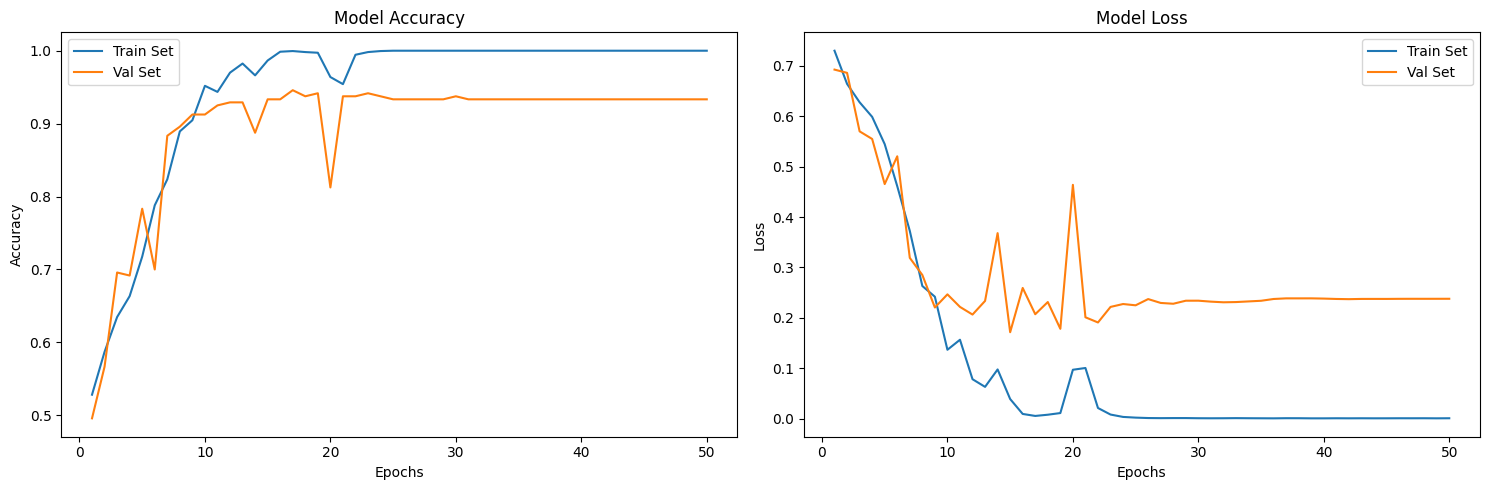

19/19 [==============================] - 0s 6ms/step - loss: 0.1588 - accuracy: 0.9650
Test Accuracy:  96.5
              precision    recall  f1-score   support

         yes     0.9761    0.9533    0.9646       300
          no     0.9544    0.9767    0.9654       300

    accuracy                         0.9650       600
   macro avg     0.9653    0.9650    0.9650       600
weighted avg     0.9653    0.9650    0.9650       600



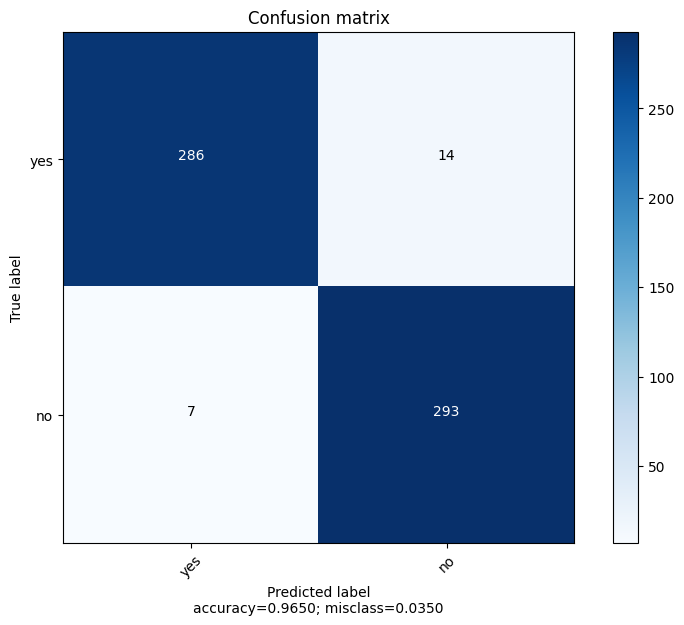

In [21]:
model = load_model()
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='DNNwithSVM.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])

draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

## VGG19-TLFT

![](VGG19TLFT.png)